In [ ]:
## 출처: 딥러닝을 이용한 자연어 처리 입문
## RNN을 이용한 텍스트 분류 - 네이버 쇼핑 리뷰 감정 분석

# Mecab 모듈 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [2]:
# 리뷰 데이터 전처리를 위한 모듈 불러오기
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# 데이터 다운받기
## 데이터 출처: 20.6~7월 동안의 네이버 쇼핑 제품들의 후기 20만 건 데이터, 별점(1, 2, 4, 5)과 후기 텍스트로 구성
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f2261591210>)

In [4]:
# txt 파일 불러와서 컬럼 추가
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

# 전체 리뷰 갯수 출력
len(total_data)  # 200000

200000

In [6]:
# 데이터 샘플 5개 출력
total_data.head(5)

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [7]:
# 평점 데이터로 레이블 데이터 생성
## 평점이 4, 5면 레이블 -> 1
## 평점이 1, 2면 레이블 -> 0 (평점 3점이 없음)
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
# numpy 사용 하지 않고 lambda 함수로 적으면
# total_data['label'] = total_data['reviews'].apply(lambda x: 1 if x in [4, 5] else 0)

total_data.head(5)

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [8]:
# 중복을 제외한 각 컬럼의 샘플의 수 카운트
print(total_data['ratings'].nunique())  # unique 앞에 n을 붙이면 갯수를 출력
print(total_data['reviews'].nunique())
print(total_data['label'].nunique())

4
199908
2


In [9]:
# 리뷰 컬럼에서 중복 데이터 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)
len(total_data)  # 중복 데이터 제거하고 총 갯수 200000 -> 199908

199908

In [10]:
# 결측치 확인
total_data.isnull().sum()

,0
ratings,0
reviews,0
label,0


In [11]:
# 훈련, 테스트 데이터 분리
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)
print(train_data.shape, test_data.shape)

(149931, 3) (49977, 3)


<Axes: xlabel='label'>

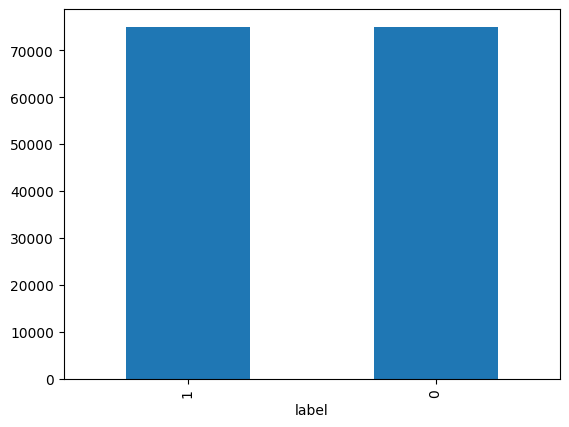

In [12]:
# 레이블 데이터의 분포 확인(비율 확인) - 그래프로 확인
train_data['label'].value_counts().plot(kind='bar')

In [13]:
# 분포 레이블 갯수 확인
train_data.groupby('label').size().reset_index(name='count')  # 50:50 비율로 레이블이 분포함

,label,count
0,0,74918
1,1,75013


In [14]:
# 텍스트 데이터 정제하기
## 정규 표현식을 사용해서 한글을 제외하고 모두 제거하고, 공백을 null 값으로 대치
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
train_data['reviews'] = train_data['reviews'].replace('', np.nan)
train_data.isnull().sum()

,0
ratings,0
reviews,0
label,0


In [15]:
# 테스트 데이터도 위 작업 적용 (중복 데이터 제거 -> 한글 외 제거 -> 공백 null로 대치)
test_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
test_data['reviews'] = test_data['reviews'].replace('', np.nan)
test_data = test_data.dropna(how='any')  # null 값 제거
len(test_data)

49977

In [16]:
# 토큰화 작업
mecab = Mecab()
stopwords = [ '도', '는', '다', '의', '가', '이', '은', '한', '에', '하',
              '고', '을', '를', '인', '듯', '과', '와', '네', '들', '지',
              '임', '게' ]  # 분석에 의미없는 불용어를 먼저 지정 (후에 불용어 제거 수행)

In [17]:
# 훈련 데이터 토큰화 과정 수행
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])  # 불용어 제거

In [18]:
# 테스트 데이터 토큰화 과정 수행
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])  # 불용어 제거

In [19]:
# 단어와 길이 분포 확인하기
## 라벨 데이터 0, 1에 따라 각 부정, 긍정 단어에 할당
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [20]:
# 각 단어별 빈도수 카운트
## 부정 단어 카운트
negative_word_count = Counter(negative_words)
negative_word_count.most_common(20)  # 빈도수가 높은 상위 20개 단어 출력

[('네요', 31802),
 ('는데', 20197),
 ('안', 19719),
 ('어요', 14838),
 ('있', 13200),
 ('너무', 13057),
 ('했', 11766),
 ('좋', 9803),
 ('배송', 9677),
 ('같', 8997),
 ('어', 8929),
 ('구매', 8869),
 ('거', 8861),
 ('없', 8672),
 ('아요', 8640),
 ('습니다', 8436),
 ('그냥', 8355),
 ('되', 8345),
 ('잘', 8029),
 ('않', 7985)]

In [21]:
## 긍정 단어 카운트
positive_word_count = Counter(positive_words)
positive_word_count.most_common(20)

[('좋', 39422),
 ('아요', 21186),
 ('네요', 19894),
 ('어요', 18673),
 ('잘', 18603),
 ('구매', 16165),
 ('습니다', 13320),
 ('있', 12391),
 ('배송', 12274),
 ('는데', 11635),
 ('합니다', 9801),
 ('했', 9783),
 ('먹', 9640),
 ('재', 9274),
 ('너무', 8398),
 ('같', 7867),
 ('만족', 7259),
 ('거', 6484),
 ('어', 6330),
 ('쓰', 6291)]

긍정 리뷰의 평균 길이: 13.579646194659592
부정 리뷰의 평균 길이: 17.031501107877947


Text(0.5, 0.98, 'Words in texts')

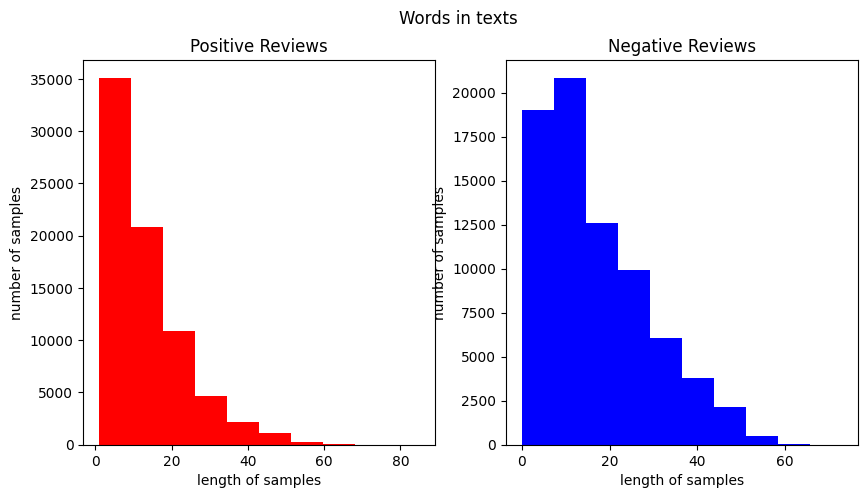

In [23]:
# 각 단어의 길이 분포 그래프로 확인
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 그래프 틀 생성
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red') # 히스토그램
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이:', np.mean(text_len))

text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이:', np.mean(text_len))

fig.suptitle('Words in texts')

# 긍정 리뷰(왼쪽) 보다는 부정 리뷰(오른쪽)가 더 길게 작성된 경향이 있다.

In [24]:
# 훈련, 테스트 데이터에서 레이블(y) 분할
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(149931,) (149931,) (49977,) (49977,)


In [25]:
# 정수로 인코딩하기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # 훈련 데이터에 대해서 단어 집합 만들기

In [26]:
# 등장 횟수가 1회인 단어들은 자연어 처리에서 배제
threshold = 2
total_cnt = len(tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold 보다 작은 단어의 갯수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold 보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받음
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):  # 만약 단어의 등장 빈도수가 threshold 보다 작으면
        rare_cnt = rare_cnt + 1  # rare_cnt를 1개씩 세고(1을 더하고)
        rare_freq = rare_freq + value  # value 값을 rare 빈도수 총 합에 합산해라

print('단어 집합(vocabulary)의 크기:', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))  # 문자열 포맷팅: %s는 문자열, %d는 정수
print('단어 집합에서 희귀 단어(등장 횟수 1번)의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율(전체 등장 빈도 중 1번만 등장하는 비율):', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기: 40126
등장 빈도가 1번 이하인 희귀 단어의 수: 18274
단어 집합에서 희귀 단어(등장 횟수 1번)의 비율: 45.54154413597169
전체 등장 빈도에서 희귀 단어 등장 빈도 비율(전체 등장 빈도 중 1번만 등장하는 비율): 0.7963859748210594


In [27]:
## 위 수치를 해석하면
# 단어가 약 40,000개 존재
# 그 중에서 등장 빈도가 1회인 단어들은 단어 집합에서 약 45%를 차지
# 하지만 훈련 데이터에서 등장 빈도로 차지하는 비중은 약 0.8%로 매우 작은 수치
# 차지하는 비중이 매우 적으므로 자연어 처리에서 중요하지 않을 것으로 판단 -> 인코딩 과정에서 배제
# 등장 빈도수가 1인 단어들의 수를 제외한 단어의 갯수를 단어 집합의 최대 크기로 제한

In [28]:
# 전체 단어 갯수 중 빈도수 2 이하인 단어 갯수는 제거
# 0번 패딩 토큰과 1번 00V 토큰을 고려하여 +2 적어 줌
vocab_size = total_cnt - rare_cnt + 2
vocab_size  # 단어 집합의 크기: 21854 -> 이 숫자를 토크나이저의 인자로 넘겨준다.

21854

In [29]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
# X_train, X_test 상위 3개 샘플 출력
X_train[:3]

[[67,
  2060,
  300,
  14295,
  263,
  73,
  6,
  237,
  168,
  136,
  801,
  2940,
  626,
  2,
  76,
  62,
  207,
  40,
  1344,
  155,
  3,
  6],
 [482, 400, 52, 8525, 2592, 2450, 338, 2941, 251, 2351, 39, 473, 2],
 [45,
  24,
  832,
  104,
  35,
  2366,
  160,
  7,
  10,
  8058,
  4,
  1319,
  30,
  138,
  323,
  44,
  59,
  160,
  138,
  7,
  1916,
  2,
  113,
  163,
  1385,
  307,
  119,
  135]]

In [31]:
X_test[:3]

[[14, 704, 767, 115, 186, 252, 12],
 [338, 3907, 62, 3819, 1624],
 [11, 69, 2, 49, 164, 3, 27, 15, 6, 514, 289, 17, 92, 110, 584, 59, 7, 2]]

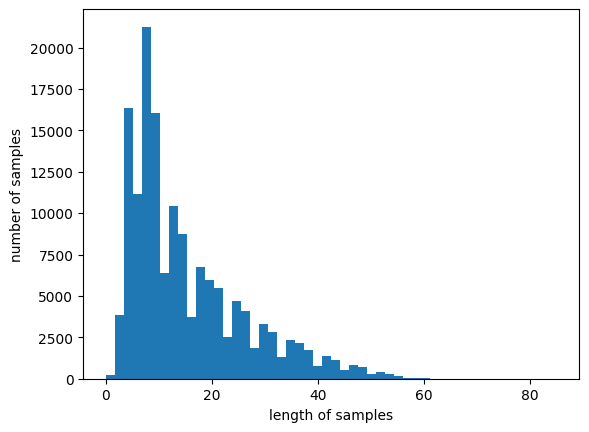

In [32]:
# 패딩 작업 - 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰 줌
## 샘플 길이 분포 파악
max(len(review) for review in X_train)  # 리뷰 최대 길이: 85
sum(map(len, X_train))/len(X_train)  # 리뷰 평균 길이: 약 15.30
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
# 적절한 패딩 수치를 찾기 위해 해당 임계값 이하인 샘플 비율 구하는 함수 생성
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print(max_len, (count / len(nested_list)) * 100)

max_len = 80 # 문장 최대 길이가 80일 경우 몇개의 샘플을 보전할 수 있는지 확인
below_threshold_len(max_len, X_train)  # 99.99%가 80이하의 길이를 가짐

80 99.99933302652553


In [34]:
# 길이 80으로 훈련용 리뷰 데이터 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [35]:
# GRU 모델로 네이버 쇼핑 리뷰 감성 분류하기
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100  # 임베딩 벡터 차원 100
hidden_units = 128   # 은닉 상태의 크기 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8511 - loss: 0.3559
Epoch 1: val_acc improved from -inf to 0.91293, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - acc: 0.8512 - loss: 0.3558 - val_acc: 0.9129 - val_loss: 0.2409
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9173 - loss: 0.2297
Epoch 2: val_acc did not improve from 0.91293
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - acc: 0.9173 - loss: 0.2297 - val_acc: 0.9098 - val_loss: 0.2363
Epoch 3/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9270 - loss: 0.2043
Epoch 3: val_acc improved from 0.91293 to 0.92057, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - acc: 0.9270 - loss: 0.2043 - val_acc: 0.9206 - val_loss: 0.2181
Epoch 4/20
1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9334 - loss: 0.1896
Epoch 4: val_acc improved from 0.92057 to 0.92323, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step

In [36]:
# 저장한 모델 불러와서 모델 지표 확인
loaded_model = load_model('best_model.keras')
loaded_model.evaluate(X_test, y_test)[1]  # 테스트 정확도: 0.9217

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.9235 - loss: 0.2150


0.9217039942741394

In [44]:
# 새로 작성한 문장으로 예측하기 위해 함수 생성
## 새 입력 데이터 동일한 전처리 수행  # 한국어 외 문자 제거, 토큰화, 불용어 제거, 정수 인코딩, 패딩
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen=max_len)

    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [38]:
# 새 리뷰 예측
sentiment_predict('이 상품 진짜 좋아요... 강추합니다. 대박')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
95.72% 확률로 긍정 리뷰입니다.


<ipython-input-37-583ac4ea179e>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [39]:
sentiment_predict('재구매 의향 있어요!!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
84.52% 확률로 긍정 리뷰입니다.


<ipython-input-37-583ac4ea179e>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [52]:
sentiment_predict('판매자님 사랑합니다! 많이 파세요~~')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
81.75% 확률로 긍정 리뷰입니다.


<ipython-input-44-ba0d510064c5>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [46]:
sentiment_predict('별로에요..')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
99.89% 확률로 부정 리뷰입니다.


<ipython-input-44-ba0d510064c5>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [47]:
sentiment_predict('돈이 너무 아까워요..')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
99.67% 확률로 부정 리뷰입니다.


<ipython-input-44-ba0d510064c5>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))
